# CLEAN BUILD FROM SCRATCH EFFNET-UNET b7 on patches

In [1]:
CURRENT_FOLD = 3

# imports

In [2]:
import random

import numpy as np
import pandas as pd
import cv2 as cv
import os

from matplotlib import pyplot as plt
from glob import glob
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm
from IPython.display import clear_output

import albumentations as A
import albumentations.pytorch

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import torch.cuda.amp as amp
is_amp = True

In [3]:
torch.multiprocessing.set_start_method('spawn')

# data

In [4]:
ORGAN2ID = {
    'kidney' : 0,
    'prostate' : 1,
    'largeintestine' : 2,
    'spleen' : 3,
    'lung' : 4
}
ID2ORGAN = {v: k for k, v in ORGAN2ID.items()}

# model testing

In [5]:
from model import Net
from mit import *
from torch.optim.swa_utils import AveragedModel, SWALR

## data 512

In [6]:
# img256 = cv.imread('./../data/train_data_eunet_patches/256/train/10044_0000.png')
# img512 = cv.imread('./../data/train_data_eunet_patches/512/train/10044_0000.png')

In [7]:
TRAIN_CSV = './../data/train.csv'
TEST_CSV = './../data/test.csv'
TRAIN_IMAGES_DIR = './../data/train_data_eunet_patches/512/train/'
TRAIN_MASKS_DIR = './../data/train_data_eunet_patches/512/masks/'

N_CROSS_VALID_SPLITS = 5
RANDOM_SEED = 2022

SPATIAL_SIZE = 512 # размер патча


In [8]:
train_df = pd.read_csv(TRAIN_CSV)

In [9]:
def make_train_image_path(row):
    return os.path.join(TRAIN_IMAGES_DIR, str(row['id']) + '.png')

def make_train_mask_path(row):
    return os.path.join(TRAIN_MASKS_DIR, str(row['id']) + '.png')

def create_folds(df: pd.DataFrame, n_splits: int, random_seed: int) -> pd.DataFrame:
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)
    for fold, (_, val_idx) in enumerate(skf.split(X=df, y=df["organ"])):
        df.loc[val_idx, "fold"] = int(fold)

    return df

In [10]:
train_df = create_folds(train_df, n_splits=N_CROSS_VALID_SPLITS, random_seed=RANDOM_SEED)

In [11]:
train_df.head()

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex,fold
0,10044,prostate,HPA,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 14...,37.0,Male,4.0
1,10274,prostate,HPA,3000,3000,0.4,4,715707 2 718705 8 721703 11 724701 18 727692 3...,76.0,Male,0.0
2,10392,spleen,HPA,3000,3000,0.4,4,1228631 20 1231629 24 1234624 40 1237623 47 12...,82.0,Male,0.0
3,10488,lung,HPA,3000,3000,0.4,4,3446519 15 3449517 17 3452514 20 3455510 24 34...,78.0,Male,0.0
4,10610,spleen,HPA,3000,3000,0.4,4,478925 68 481909 87 484893 105 487863 154 4908...,21.0,Female,4.0


In [12]:
def make_512_dataset(df):
    new_df = []
    for index, row in df.iterrows():
        id = row['id']
        glb = list(glob(TRAIN_IMAGES_DIR + '{}_*.png'.format(id)))
        for fname in glb:
            newrow = dict()
            newrow['id'] = id
            newrow['image'] = fname
            newrow['mask'] = fname.replace('/train/', '/masks/')
            newrow['organ'] = row['organ']
            newrow['pixel_size'] = row['pixel_size']
            newrow['fold'] = row['fold']
            
            new_df.append(newrow)
    return pd.DataFrame(new_df)

In [13]:
train_df_512 = make_512_dataset(train_df)
print(train_df_512.shape)
train_df_512.head()

(2895, 6)


,fold,id,image,mask,organ,pixel_size
0,4.0,10044,./../data/train_data_eunet_patches/512/train/1...,./../data/train_data_eunet_patches/512/masks/1...,prostate,0.4
1,4.0,10044,./../data/train_data_eunet_patches/512/train/1...,./../data/train_data_eunet_patches/512/masks/1...,prostate,0.4
2,4.0,10044,./../data/train_data_eunet_patches/512/train/1...,./../data/train_data_eunet_patches/512/masks/1...,prostate,0.4
3,4.0,10044,./../data/train_data_eunet_patches/512/train/1...,./../data/train_data_eunet_patches/512/masks/1...,prostate,0.4
4,4.0,10044,./../data/train_data_eunet_patches/512/train/1...,./../data/train_data_eunet_patches/512/masks/1...,prostate,0.4


In [14]:
# ---------------------------------------------------------------
# WARNING! THIS RESCALE IS INJECTED IN SWIN TRANSFORMER ALREADY!
#   RGB LAYER
# IT'S INPUTS HAVE TO BE IMAGE IN 0..1!
# ---------------------------------------------------------------

In [15]:
# mean = np.array([0.7720342, 0.74582646, 0.76392896])
# std = np.array([0.24745085, 0.26182273, 0.25782376])

In [16]:
train_transform= A.Compose([
    A.Resize(512, 512, interpolation=cv.INTER_LINEAR),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.HueSaturationValue(p=0.25),
    A.ShiftScaleRotate(shift_limit=0.02, scale_limit=(0.05, 0.6),rotate_limit=90, p=0.5),
    A.ElasticTransform(p=0.1, alpha=90, sigma=120 * 0.05, alpha_affine=120 * 0.03),
    A.GridDistortion(p=0.25),
    A.Blur(blur_limit=5, p=0.1),
    A.GaussNoise(var_limit=(20, 100), p=0.2),
    A.ChannelDropout(p=0.05),
    A.RandomGamma(p=0.1),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=[0, 0, 0], std=[1, 1, 1], 
                max_pixel_value=255, always_apply=True),
    albumentations.pytorch.ToTensorV2()
], p=1)

In [17]:
val_transform = A.Compose([
#     A.Resize(512, 512, interpolation = cv.INTER_LINEAR),
    A.Normalize(mean=[0, 0, 0], std=[1, 1, 1],
                 max_pixel_value=255, always_apply=True),
    albumentations.pytorch.ToTensorV2()
], p=1)

In [18]:
class HubmapDataset512(Dataset):
    def __init__(self, df, transform=None):

        self.df = df
        self.transform = transform
        self.length = len(self.df)

    def __str__(self):
        string = ''
        string += '\tlen = %d\n' % len(self)

        d = self.df.organ.value_counts().to_dict()
        for k in ['kidney', 'prostate', 'largeintestine', 'spleen', 'lung']:
            string +=  '%24s %3d (%0.3f) \n'%(k,d.get(k,0),d.get(k,0)/len(self.df))
        return string

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        print(index)
        d = self.df.iloc[index]
        organ = ORGAN2ID[d['organ']]

        image = cv.cvtColor(cv.imread(d['image']), cv.COLOR_BGR2RGB) # .astype(np.float32) / 255.0
        mask = cv.imread(d['mask'], cv.IMREAD_GRAYSCALE)

        mask = mask / max(1, mask.max())
        
        mask_multiclass = mask * (organ + 1)
        
        data = {
            'image': image,
            'mask': mask_multiclass,
            'organ': organ,
        }
        
        upd_data = self.transform(image=data['image'], mask=data['mask'])
        upd_data['image'] = upd_data['image'].to('cuda:2')

        data.update(upd_data)
        return data

In [19]:
def worker_init_fn(worker_id):
    torch_seed = torch.initial_seed()
    random.seed(torch_seed + worker_id)
    if torch_seed >= 2**30:  # make sure torch_seed + workder_id < 2**32
        torch_seed = torch_seed % 2**30
    np.random.seed(torch_seed + worker_id)
    random.seed(torch_seed + worker_id + 77777)

In [20]:
train_dataset = HubmapDataset512(train_df_512[train_df_512['fold'] != CURRENT_FOLD], train_transform)
val_dataset = HubmapDataset512(train_df_512[train_df_512['fold'] == CURRENT_FOLD], val_transform)

1
IMAGE
torch.Size([3, 512, 512])
image values:  0.13333334028720856 1.0


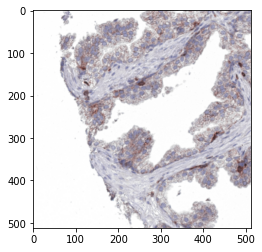

MASK
torch.Size([512, 512])
mask values:  tensor(0., dtype=torch.float64) tensor(2., dtype=torch.float64)


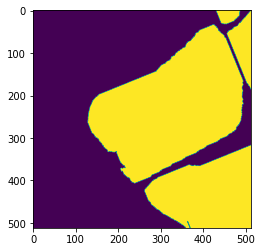

In [21]:
sample = train_dataset[1]
print('IMAGE')
print(sample['image'].shape)
print('image values: ', float(sample['image'].min()), float(sample['image'].max()))
plt.imshow(sample['image'].detach().cpu().permute((1, 2, 0)))
plt.show()

print('MASK')
print(sample['mask'].shape)
print('mask values: ', sample['mask'].min(), sample['mask'].max())
plt.imshow(sample['mask'])
plt.show()

In [22]:
BATCH_SIZE = 10

In [32]:
loader_params = {'shuffle': True,
                 'num_workers': 0,
                 'worker_init_fn': worker_init_fn}
loader_train = DataLoader(train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True,
                          worker_init_fn=worker_init_fn,
                          num_workers=0
                         )
loader_val = DataLoader(val_dataset, 
                        batch_size=1, 
                        shuffle=False,
                        worker_init_fn=worker_init_fn,
                        num_workers=0
                       )

2
IMAGE
torch.Size([3, 512, 512])
image values:  0.0 1.0


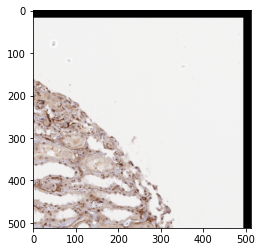

MASK
torch.Size([512, 512])
mask values:  tensor(0., dtype=torch.float64) tensor(1., dtype=torch.float64)


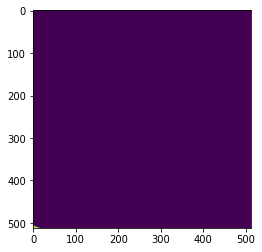

In [33]:
sample = val_dataset[2]
print('IMAGE')
print(sample['image'].shape)
print('image values: ', float(sample['image'].min()), float(sample['image'].max()))
plt.imshow(sample['image'].detach().cpu().permute((1, 2, 0)))
plt.show()

print('MASK')
print(sample['mask'].shape)
print('mask values: ', sample['mask'].min(), sample['mask'].max())
plt.imshow(sample['mask'])
plt.show()

# model

In [34]:
device = 'cuda:2'
DEVICE = device

In [35]:
model = Net().to(device)

In [36]:
swa_model = AveragedModel(model)

In [37]:
swa_model.load_state_dict(torch.load('./checkpoint_fold_3/mit-b2_swa_ep_135_dice_0.758839.pt', map_location=device))

<All keys matched successfully>

In [38]:
torch.optim.swa_utils.update_bn(loader_train, swa_model)

910
1795
1780
387
1131
1011
961
350
1842
1482
1629
2093
274
670
730
885
1342
358
1963
2194
418
194
711
1640
692
1878
155
1448
568
94
610
2291
1835
1926
76
304
1268
361
1879
397
909
1556
1755
440
601
1664
881
796
1975
1031
37
369
179
819
1126
1702
1617
1346
904
1049
354
388
130
2046
2304
1858
528
1480
2090
472
748
389
519
522
1355
941
599
1180
1086
25
749
53
1974
699
1351
1343
633
1881
1173
764
1158
1456
356
383
447
1130
527
391
1757
1955
185
2103
1883
1832
827
1139
237
2183
1647
111
531
1916
1715
809
2204
1068
1769
342
781
1216
348
1499
116
1227
1245
1363
306
480
1487
1289
2084
1323
339
580
177
469
345
719
1392
621
655
1720
1339
767
1643
1065
2247
2189
1764
1223
1794
1933
1606
2135
2028
1967
756
1762
1388
2257
475
678
1338
1314
2234
1782
912
351
811
1856
1666
2109
1714
1335
2088
1017
2153
1535
535
2154
953
1786
1650
1135
1528
466
315
1493
686
1399
2249
1150
1830
665
504
139
668
1445
1271
821
79
360
1430
240
1917
510
1775
1061
533
825
427
134
1527
443
886
523
2192
419
1438
2000
560
1690

978
1627
1684
2042
2064
439
2294
198
1867
1231
495
969
55
1206
492
1303
1888
1059
277
203
1533
1695
648
1203
1590
1146
181
1973
1360
2239
2
1285
1569
851
1411
1657
1147
18
650
180
666
2237
159
1585
1812
2007
1998
1092
502
906
860
1001
1249
2218
425
407
1604
2003
1547
219
45
745
227
82
1166
1997
2208
2268
2102
1382
67
1789
992
2203
2191
1760
1852
1159
1544
415
474
191
302
727
1920
2242
2205
1572
1255
2255
1567
2278
1376
422
1512
300
1887
611
364
2117
1192
2058
1613
617
2280
797
129
402
731
2170
12
1803
1619
408
1110
43
544
367
204
1922
973
2202
2187
86
2010
74
1793
913
2171
2082
1711
72
2172
1007
687
485
1060
709
1936
1053
500
1132
1573
798
338
1558
2067
1284
373
570
1218
737
26
1983
1735
1609
2158
1982
357
172
1207
505
1085
1279
1256
2185
404
744
241
390
2197
1486
49
119
1066
1698
316
2065
29
636
1724
1540
2186
2292
1348
1508
1156
255
1966
1003
1744
85
2167
2057
1033
2307
115
2025
1845
1233
726
376
1763
186
1882
1435
2100
1673
2207
1872
158
1336
884
328
963
2281
1021
708
776
940
380
37

In [39]:
model = swa_model.eval()

In [40]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

25783529

# validation code

In [41]:
import monai
from monai.utils.enums import BlendMode, PytorchPadMode
from monai.inferers import sliding_window_inference

In [42]:
def dice_coef2(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    union = np.sum(y_true_f) + np.sum(y_pred_f)
    if union < 1: 
        return 1
    intersection = np.sum(y_true_f * y_pred_f)
#     print('UNION', union)
    return 2. * intersection / union

In [43]:
class Predictor(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    
    def forward(self, x):
        out = self.model({'image' : x})
        prob = F.softmax(out['out_logits'], dim=1)
        return prob

In [60]:
def infer_id(predictor, id: str, organ: str, pixel_size=0.4, threshold=0.5):
    THRESHOLD = threshold
    
    image = cv.imread('./../data/train_images/{}.tiff'.format(id))
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    
    gt_mask  = np.load('./../data/train_masks/{}.npy'.format(id))
    
    scale_factor = 0.5 * (pixel_size / 0.4)
    image = cv.resize(image, None, fx=scale_factor, fy=scale_factor, interpolation=cv.INTER_AREA)
    
#     image_rot = image.copy()
    masks = []
    for _ in range(1):
#         image_rot = cv.rotate(image, cv.ROTATE_90_CLOCKWISE)
        
        image_tensor = val_transform(image=image)['image']

        image_tensor = image_tensor.unsqueeze(0).to(device)

        with torch.no_grad():
            infer_result = sliding_window_inference(
                image_tensor, roi_size=(512, 512), sw_batch_size=2, predictor=predictor, 
                overlap=0.25, mode=BlendMode.CONSTANT, sigma_scale=0.125, 
                padding_mode=PytorchPadMode.CONSTANT, cval=0.0,       
            )

        organ_id = ORGAN2ID[organ] + 1
        pr_mask = infer_result.detach().cpu().numpy()[0, organ_id]
#         pr_mask = infer_result.detach().cpu().numpy()[0, 1:].sum(axis=1)
        
        masks.append(pr_mask)
        
    pr_mask = (np.array(masks).mean(axis=0) > THRESHOLD).astype(np.uint8)
#     print(gt_mask.shape, gt_mask.dtype, pr_mask.dtype)
    pr_mask = cv.resize(pr_mask, gt_mask.shape, cv.INTER_NEAREST)
    
    return pr_mask, gt_mask

In [61]:
def check_dice_by_thresh(val_df, model, th):
    predictor = Predictor(model)
    
    dices = []
    for index, row in tqdm(val_df.iterrows(), total=len(val_df)):
        id = row['id']
        organ = row['organ']
        pixel_size = row['pixel_size']
        pred_mask, gt_mask = infer_id(predictor, id, organ=organ, pixel_size=pixel_size, threshold=th)
        dice = dice_coef2(gt_mask, pred_mask)
        dices.append(dice)
    return np.mean(dices)

In [62]:
val_df_id = train_df[train_df['fold'] == CURRENT_FOLD]

In [63]:
check_dice_by_thresh(val_df_id, model, th=0.55)

100%|██████████| 70/70 [00:31<00:00,  2.22it/s]


0.7638214814456409

In [49]:
# torch.save(swa_model.state_dict(), os.path.join(
#                     './checkpoint_fold_{}'.format(CURRENT_FOLD), 
#                     'mit-b2_swa_ep_{:03d}_corrected_bn.pt'.format(135)
#                 )) 

#### lung

In [50]:
df_lung = val_df_id[val_df_id['organ'] == 'lung']

In [51]:
df_lung.shape

(10, 11)

In [52]:
for th in [0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]:
    dc = check_dice_by_thresh(df_lung, model, th=th)
    print('th =', th, 'dice =', dc)

100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


th = 0.05 dice = 0.1844145476215896


100%|██████████| 10/10 [00:04<00:00,  2.20it/s]


th = 0.1 dice = 0.18640942563907617


100%|██████████| 10/10 [00:04<00:00,  2.15it/s]


th = 0.15 dice = 0.18749290595353627


100%|██████████| 10/10 [00:04<00:00,  2.14it/s]


th = 0.2 dice = 0.18830571521917433


100%|██████████| 10/10 [00:04<00:00,  2.14it/s]


th = 0.3 dice = 0.1906013449822143


100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


th = 0.4 dice = 0.18565609727500929


100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


th = 0.5 dice = 0.1708803524788669


100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


th = 0.6 dice = 0.16619171441213226


100%|██████████| 10/10 [00:04<00:00,  2.21it/s]


th = 0.7 dice = 0.1607332607447996


100%|██████████| 10/10 [00:04<00:00,  2.14it/s]

th = 0.8 dice = 0.14319570428881362
